## Data Preprocessing on reddit_social_issues_cleaned

In [3]:
import pandas as pd
import re
import json
import spacy
from textblob import TextBlob
from tqdm import tqdm

# Load spaCy English model
import en_core_web_sm
nlp = en_core_web_sm.load()

# File paths

output_path = r"preprocessed_reddit_social_issues_cleaned.json"

# Load data with proper encoding
input_path = r"reddit_social_issues_cleaned.csv"
df = pd.read_csv(
    input_path,  
    encoding="ISO-8859-1"

)
# Merge title + text (handle missing values)
df['title'] = df['title'].fillna('')
df['text'] = df['text'].fillna('')
df['merged_text'] = df['title'] + " " + df['text']

# Clean and filter data
df = df.dropna(subset=['label'])  # Remove rows with missing labels
df = df[df['merged_text'].str.strip() != '']  # Remove empty texts

# Check available categories
print("Available categories:", df['label'].unique())

# Define urgency keywords
urgency_keywords = {'urgent', 'emergency', 'immediately', 'asap', 'critical', 'important', 'now'}

# Preprocessing functions
def clean_text(text):
    text = re.sub(r"http\S+|www\S+", "", text)  # Remove URLs
    text = re.sub(r"[^\w\s]", "", text)         # Remove special characters
    text = text.lower().strip()                 # Lowercase
    return text

def lemmatize(text):
    doc = nlp(text)
    return " ".join([token.lemma_ for token in doc if not token.is_stop and token.is_alpha and len(token.text) > 2])

def get_sentiment(text):
    return round(TextBlob(text).sentiment.polarity, 3)

def has_urgency(text):
    return any(word in text.lower() for word in urgency_keywords)

# Apply preprocessing
tqdm.pandas()
df['clean_text'] = df['merged_text'].progress_apply(lambda x: lemmatize(clean_text(x)))
df['sentiment'] = df['merged_text'].progress_apply(get_sentiment)
df['urgent'] = df['merged_text'].progress_apply(has_urgency)

# Print category counts
print("\n✅ Label distribution:")
print(df['label'].value_counts())

# Save as JSONL
with open(output_path, 'w', encoding='utf-8') as f:
    for _, row in df.iterrows():
        json.dump({
            "text": row['clean_text'],
            "label": row['label'],
            "sentiment": row['sentiment'],
            "urgent": row['urgent']
        }, f)
        f.write("\n")

print(f"\n✅ Preprocessed {len(df)} rows saved to: {output_path}")

Available categories: ['Electricity' 'Water' 'Traffic' 'Waste Management' 'Security']


100%|██████████| 5451/5451 [00:00<00:00, 118647.58it/s]



✅ Label distribution:
label
Traffic             1174
Water               1169
Electricity         1102
Security            1074
Waste Management     932
Name: count, dtype: int64

✅ Preprocessed 5451 rows saved to: preprocessed_reddit_social_issues_cleaned.json


### modeling_LG_TFIDF

In [2]:
import os
import json
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
import torch
from torch.utils.data import Dataset

In [4]:
# Create output directory if it doesn't exist
os.makedirs('modeling_LG_TFIDF', exist_ok=True)

# Load JSON data (handle JSONL format)
file_path = 'preprocessed_reddit_social_issues_cleaned.json'
data = []
with open(file_path, 'r') as f:
    for line in f:
        try:
            data.append(json.loads(line.strip()))
        except json.JSONDecodeError as e:
            print(f"Error in line: {line.strip()} - {e}")

# Convert to DataFrame
df = pd.DataFrame(data)

# Data exploration
print("Label Distribution:")
print(df['label'].value_counts())
print("\nSample Data:")
print(df.head())

# Encode labels
label_encoder = LabelEncoder()
df['label_encoded'] = label_encoder.fit_transform(df['label'])

# Prepare features
X_text = df['text']
X_sentiment = df['sentiment'].values.reshape(-1, 1)
X_urgent = df['urgent'].astype(int).values.reshape(-1, 1)
y = df['label_encoded']

# Train-test split
X_text_train, X_text_test, X_sentiment_train, X_sentiment_test, X_urgent_train, X_urgent_test, y_train, y_test = train_test_split(
    X_text, X_sentiment, X_urgent, y, test_size=0.2, random_state=42, stratify=y
)


Label Distribution:
label
Traffic             1174
Water               1169
Electricity         1102
Security            1074
Waste Management     932
Name: count, dtype: int64

Sample Data:
                                                text        label  sentiment  \
0           loadshedding city recently new title say  Electricity      0.068   
1  loadsheddingpower breakdown dhabay jeegharo co...  Electricity      0.000   
2               shehbaz warn public loadshedde month  Electricity      0.167   
3  national grid reduce supply karachi shahbaz ta...  Electricity      0.525   
4  pakistan free loadshedde tonight midnight chai...  Electricity      0.400   

   urgent  
0   False  
1   False  
2   False  
3   False  
4   False  


###  Logistic Regression with TF-IDF


Logistic Regression Classification Report:
                  precision    recall  f1-score   support

     Electricity       0.92      0.89      0.90       221
        Security       0.93      0.90      0.92       215
         Traffic       0.90      0.93      0.92       235
Waste Management       0.93      0.95      0.94       186
           Water       0.88      0.89      0.89       234

        accuracy                           0.91      1091
       macro avg       0.91      0.91      0.91      1091
    weighted avg       0.91      0.91      0.91      1091



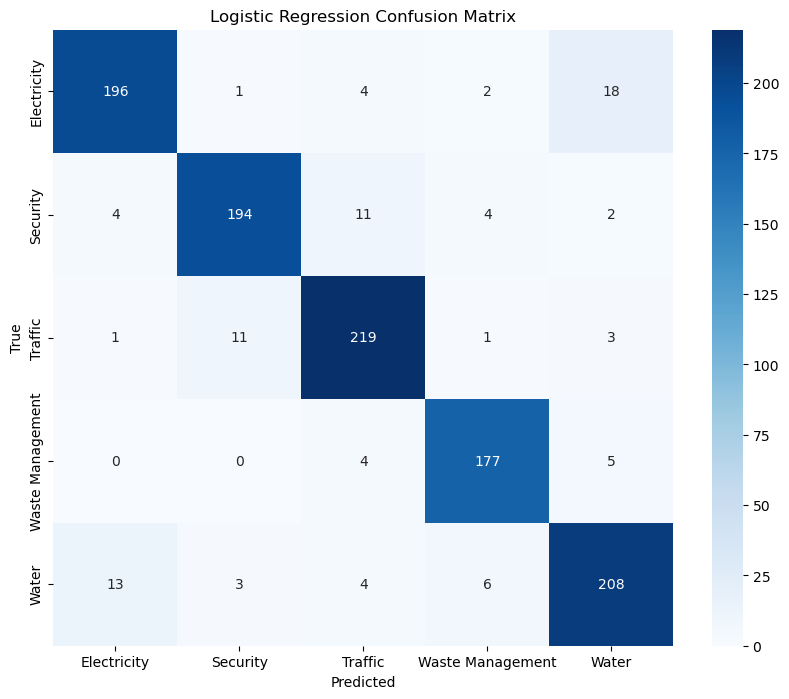

['modeling_LG_TFIDF/label_encoder.pkl']

In [5]:


# --- Baseline Model: Logistic Regression with TF-IDF ---
# TF-IDF vectorization
tfidf = TfidfVectorizer(max_features=5000)
X_text_train_tfidf = tfidf.fit_transform(X_text_train)
X_text_test_tfidf = tfidf.transform(X_text_test)

# Combine features (TF-IDF + sentiment + urgent)
X_train_combined = np.hstack((X_text_train_tfidf.toarray(), X_sentiment_train, X_urgent_train))
X_test_combined = np.hstack((X_text_test_tfidf.toarray(), X_sentiment_test, X_urgent_test))

# Train Logistic Regression
lr_model = LogisticRegression(max_iter=1000)  # Removed multi_class parameter as per warning
lr_model.fit(X_train_combined, y_train)

# Evaluate
y_pred_lr = lr_model.predict(X_test_combined)
print("\nLogistic Regression Classification Report:")
print(classification_report(y_test, y_pred_lr, target_names=label_encoder.classes_))

# Confusion matrix
cm_lr = confusion_matrix(y_test, y_pred_lr)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Logistic Regression Confusion Matrix')
plt.savefig('modeling_LG_TFIDF/lr_confusion_matrix.png')
plt.show()
plt.close()

# Save baseline model
joblib.dump(lr_model, 'modeling_LG_TFIDF/lr_model.pkl')
joblib.dump(tfidf, 'modeling_LG_TFIDF/tfidf_vectorizer.pkl')
joblib.dump(label_encoder, 'modeling_LG_TFIDF/label_encoder.pkl')

### modeling with BERT

In [14]:
# Create output directory if it doesn't exist
os.makedirs('modeling_BERT', exist_ok=True)

In [45]:
# Verify GPU and environment
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Active Conda Env: {os.environ.get('CONDA_DEFAULT_ENV')}")
print(f"CUDA Available: {torch.cuda.is_available()}")
print(f"Using Device: {device}")
if torch.cuda.is_available():
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")
    print(f"VRAM Allocated: {torch.cuda.memory_allocated(0)/1024**2:.2f} MiB")

Active Conda Env: ai_env
CUDA Available: True
Using Device: cuda
GPU Name: NVIDIA GeForce MX450
VRAM Allocated: 20.00 MiB


Active Conda Env: ai_env
CUDA Available: True
Using Device: cuda
GPU Name: NVIDIA GeForce MX450
VRAM Allocated: 3142.20 MiB


c:\Users\hp\miniconda3\envs\ai_env\lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification f

  0%|          | 0/1635 [00:00<?, ?it/s]

{'loss': 1.6168, 'learning_rate': 1.0000000000000002e-06, 'epoch': 0.02}
{'loss': 1.6548, 'learning_rate': 2.0000000000000003e-06, 'epoch': 0.04}
{'loss': 1.626, 'learning_rate': 3e-06, 'epoch': 0.06}
{'loss': 1.6632, 'learning_rate': 4.000000000000001e-06, 'epoch': 0.07}
{'loss': 1.6185, 'learning_rate': 5e-06, 'epoch': 0.09}
{'loss': 1.5741, 'learning_rate': 6e-06, 'epoch': 0.11}
{'loss': 1.6163, 'learning_rate': 7.000000000000001e-06, 'epoch': 0.13}
{'loss': 1.5782, 'learning_rate': 8.000000000000001e-06, 'epoch': 0.15}
{'loss': 1.5746, 'learning_rate': 9e-06, 'epoch': 0.17}
{'loss': 1.5149, 'learning_rate': 1e-05, 'epoch': 0.18}
{'loss': 1.5482, 'learning_rate': 1.1000000000000001e-05, 'epoch': 0.2}
{'loss': 1.4014, 'learning_rate': 1.2e-05, 'epoch': 0.22}
{'loss': 1.4522, 'learning_rate': 1.3000000000000001e-05, 'epoch': 0.24}
{'loss': 1.318, 'learning_rate': 1.4000000000000001e-05, 'epoch': 0.26}
{'loss': 1.3099, 'learning_rate': 1.5e-05, 'epoch': 0.28}
{'loss': 1.215, 'learning_

  0%|          | 0/137 [00:00<?, ?it/s]

{'eval_loss': 0.258345365524292, 'eval_runtime': 506.5129, 'eval_samples_per_second': 2.154, 'eval_steps_per_second': 0.27, 'epoch': 1.0}
{'loss': 0.2652, 'learning_rate': 4.7797356828193834e-05, 'epoch': 1.01}
{'loss': 0.1735, 'learning_rate': 4.7356828193832604e-05, 'epoch': 1.03}
{'loss': 0.1314, 'learning_rate': 4.691629955947137e-05, 'epoch': 1.05}
{'loss': 0.2357, 'learning_rate': 4.647577092511014e-05, 'epoch': 1.06}
{'loss': 0.072, 'learning_rate': 4.60352422907489e-05, 'epoch': 1.08}
{'loss': 0.0219, 'learning_rate': 4.5594713656387665e-05, 'epoch': 1.1}
{'loss': 0.3217, 'learning_rate': 4.5154185022026436e-05, 'epoch': 1.12}
{'loss': 0.5428, 'learning_rate': 4.47136563876652e-05, 'epoch': 1.14}
{'loss': 0.2971, 'learning_rate': 4.427312775330397e-05, 'epoch': 1.16}
{'loss': 0.1727, 'learning_rate': 4.383259911894273e-05, 'epoch': 1.17}
{'loss': 0.2598, 'learning_rate': 4.33920704845815e-05, 'epoch': 1.19}
{'loss': 0.2706, 'learning_rate': 4.295154185022027e-05, 'epoch': 1.21}

  0%|          | 0/137 [00:00<?, ?it/s]

{'eval_loss': 0.16608913242816925, 'eval_runtime': 507.842, 'eval_samples_per_second': 2.148, 'eval_steps_per_second': 0.27, 'epoch': 2.0}
{'loss': 0.1705, 'learning_rate': 2.3568281938325993e-05, 'epoch': 2.02}
{'loss': 0.0829, 'learning_rate': 2.3127753303964757e-05, 'epoch': 2.04}
{'loss': 0.273, 'learning_rate': 2.2687224669603524e-05, 'epoch': 2.06}
{'loss': 0.2692, 'learning_rate': 2.2246696035242294e-05, 'epoch': 2.07}
{'loss': 0.0869, 'learning_rate': 2.1806167400881057e-05, 'epoch': 2.09}
{'loss': 0.1915, 'learning_rate': 2.1365638766519824e-05, 'epoch': 2.11}
{'loss': 0.2826, 'learning_rate': 2.092511013215859e-05, 'epoch': 2.13}
{'loss': 0.17, 'learning_rate': 2.048458149779736e-05, 'epoch': 2.15}
{'loss': 0.066, 'learning_rate': 2.0044052863436125e-05, 'epoch': 2.17}
{'loss': 0.2316, 'learning_rate': 1.960352422907489e-05, 'epoch': 2.18}
{'loss': 0.2909, 'learning_rate': 1.9162995594713656e-05, 'epoch': 2.2}
{'loss': 0.0943, 'learning_rate': 1.8722466960352426e-05, 'epoch':

  0%|          | 0/137 [00:00<?, ?it/s]

{'eval_loss': 0.16316403448581696, 'eval_runtime': 507.2038, 'eval_samples_per_second': 2.151, 'eval_steps_per_second': 0.27, 'epoch': 3.0}
{'train_runtime': 28869.3763, 'train_samples_per_second': 0.453, 'train_steps_per_second': 0.057, 'train_loss': 0.3762266907761221, 'epoch': 3.0}


  0%|          | 0/137 [00:00<?, ?it/s]


BERT Classification Report:
                  precision    recall  f1-score   support

     Electricity       0.93      0.98      0.95       221
        Security       0.98      0.89      0.93       215
         Traffic       0.91      0.97      0.94       235
Waste Management       0.97      0.97      0.97       186
           Water       0.96      0.92      0.94       234

        accuracy                           0.95      1091
       macro avg       0.95      0.95      0.95      1091
    weighted avg       0.95      0.95      0.95      1091



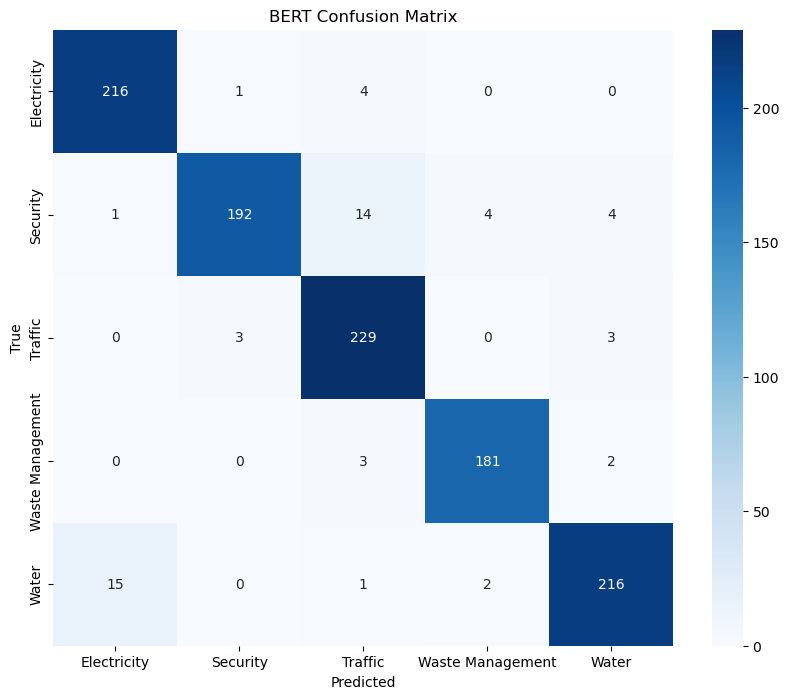

('modeling_BERT/bert_model\\tokenizer_config.json',
 'modeling_BERT/bert_model\\special_tokens_map.json',
 'modeling_BERT/bert_model\\vocab.txt',
 'modeling_BERT/bert_model\\added_tokens.json')

In [ ]:

# --- Advanced Model: BERT ---
# Custom Dataset for BERT
class SocialIssuesDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts.iloc[idx])
        label = self.labels.iloc[idx]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Initialize BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=len(label_encoder.classes_)
)

# Create datasets
train_dataset = SocialIssuesDataset(
    X_text_train.reset_index(drop=True), 
    y_train.reset_index(drop=True), 
    tokenizer
)
test_dataset = SocialIssuesDataset(
    X_text_test.reset_index(drop=True), 
    y_test.reset_index(drop=True), 
    tokenizer
)

# Training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy='epoch',
    save_strategy='epoch',
    load_best_model_at_end=True
)

# Initialize Trainer
trainer = Trainer(
    model=bert_model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset
)

# Train BERT model
trainer.train()

# Evaluate BERT
predictions = trainer.predict(test_dataset)
y_pred_bert = np.argmax(predictions.predictions, axis=1)
print("\nBERT Classification Report:")
print(classification_report(y_test, y_pred_bert, target_names=label_encoder.classes_))

# Confusion matrix for BERT
cm_bert = confusion_matrix(y_test, y_pred_bert)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_bert, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('BERT Confusion Matrix')
plt.show()
plt.savefig('modeling_BERT/bert_confusion_matrix.png')
plt.close()
# Save BERT model and tokenizer
trainer.save_model('modeling_BERT/bert_model')
tokenizer.save_pretrained('modeling_BERT/bert_model')

In [12]:
# Confusion matrix for BERT
cm_bert = confusion_matrix(y_test, y_pred_bert)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_bert, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('BERT Confusion Matrix')
plt.show
plt.savefig('modeling_BERT/bert_confusion_matrix.jpg')
plt.close()

### SVM with TFIDF

In [8]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
import os



In [9]:
os.makedirs('modeling_SVM_TFIDF', exist_ok=True)

Dataset Head:
                                                text        label  sentiment  \
0           loadshedding city recently new title say  Electricity      0.068   
1  loadsheddingpower breakdown dhabay jeegharo co...  Electricity      0.000   
2               shehbaz warn public loadshedde month  Electricity      0.167   
3  national grid reduce supply karachi shahbaz ta...  Electricity      0.525   
4  pakistan free loadshedde tonight midnight chai...  Electricity      0.400   

   urgent  
0   False  
1   False  
2   False  
3   False  
4   False  

Columns: ['text', 'label', 'sentiment', 'urgent']

Classes: ['Electricity' 'Security' 'Traffic' 'Waste Management' 'Water']
Using sentiment and urgency features.

SVM Classification Report:
                  precision    recall  f1-score   support

     Electricity       0.92      0.93      0.92       237
        Security       0.90      0.87      0.89       207
         Traffic       0.88      0.87      0.88       229
Waste Man

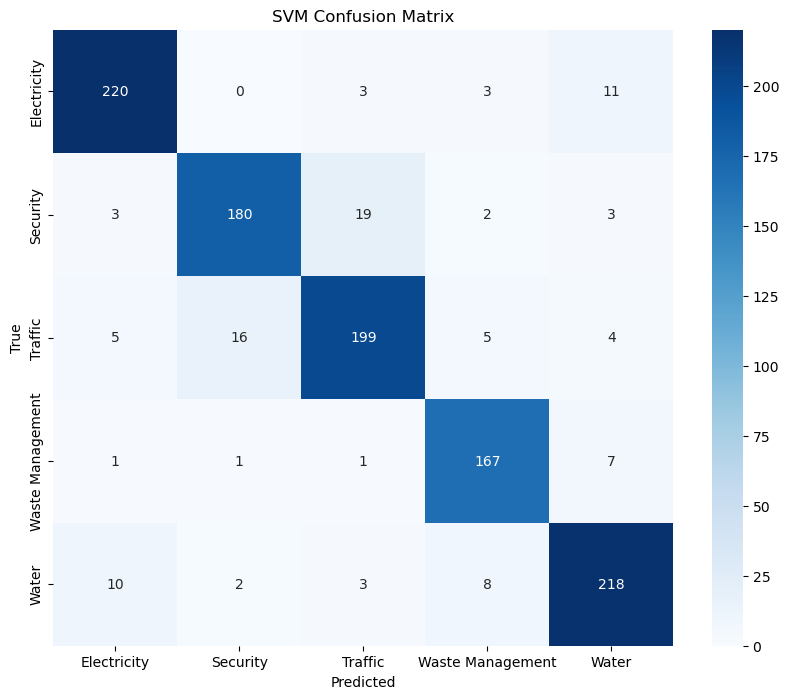

Model, vectorizer, and label encoder saved successfully.


In [55]:

# Load the JSON Lines file
file_path = 'preprocessed_reddit_social_issues_cleaned.json'  # Update with your actual path
try:
    data = pd.read_json(file_path, lines=True)
    print("Dataset Head:")
    print(data.head())
    print("\nColumns:", data.columns.tolist())
except ValueError as e:
    print(f"Error loading JSON: {e}")
    print("Please verify the file is in JSON Lines format or share its structure.")
    exit(1)

# Extract text and labels
if 'text' not in data.columns or 'label' not in data.columns:
    print("Required columns 'text' and 'label' not found. Available columns:", data.columns.tolist())
    print("Please specify correct column names.")
    exit(1)

X_text = data['text']
y = data['label']

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
print("\nClasses:", label_encoder.classes_)

# Extract additional features if available
use_additional_features = False
if 'sentiment' in data.columns and 'urgent' in data.columns:
    X_sentiment = data['sentiment'].values.reshape(-1, 1)
    X_urgent = data['urgent'].values.reshape(-1, 1)
    use_additional_features = True
    print("Using sentiment and urgency features.")
else:
    print("Sentiment or urgency features not found. Using only text features.")

# Split the data
if use_additional_features:
    X_text_train, X_text_test, X_sentiment_train, X_sentiment_test, X_urgent_train, X_urgent_test, y_train, y_test = train_test_split(
        X_text, X_sentiment, X_urgent, y_encoded, test_size=0.2, random_state=42
    )
else:
    X_text_train, X_text_test, y_train, y_test = train_test_split(
        X_text, y_encoded, test_size=0.2, random_state=42
    )

# Apply TF-IDF vectorization
tfidf = TfidfVectorizer(max_features=5000, stop_words='english')
X_text_train_tfidf = tfidf.fit_transform(X_text_train)
X_text_test_tfidf = tfidf.transform(X_text_test)

# Combine features
if use_additional_features:
    X_train_combined = np.hstack((X_text_train_tfidf.toarray(), X_sentiment_train, X_urgent_train))
    X_test_combined = np.hstack((X_text_test_tfidf.toarray(), X_sentiment_test, X_urgent_test))
else:
    X_train_combined = X_text_train_tfidf
    X_test_combined = X_text_test_tfidf

# Train SVM
svm_model = SVC(kernel='linear', C=1.0, random_state=42)
svm_model.fit(X_train_combined, y_train)

# Evaluate
y_pred_svm = svm_model.predict(X_test_combined)
print("\nSVM Classification Report:")
print(classification_report(y_test, y_pred_svm, target_names=label_encoder.classes_))

# Confusion matrix
cm_svm = confusion_matrix(y_test, y_pred_svm)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('SVM Confusion Matrix')
plt.savefig(r'modeling_SVM_TFIDF/svm_confusion_matrix.png')
plt.show()
plt.close()

# Save model and components
joblib.dump(svm_model, r'modeling_SVM_TFIDF/svm_model.pkl')
joblib.dump(tfidf, r'modeling_SVM_TFIDF/tfidf_vectorizer.pkl')
joblib.dump(label_encoder, r'modeling_SVM_TFIDF/label_encoder.pkl')
print("Model, vectorizer, and label encoder saved successfully.")

In [15]:
import torch

In [22]:
# Verify GPU and environment
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Active Conda Env: {os.environ.get('CONDA_DEFAULT_ENV')}")
print(f"CUDA Available: {torch.cuda.is_available()}")
print(f"Using Device: {device}")
if torch.cuda.is_available():
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")
    print(f"VRAM Allocated: {torch.cuda.memory_allocated(0)/1024**2:.2f} MiB")

Active Conda Env: ai_env
CUDA Available: True
Using Device: cuda
GPU Name: NVIDIA GeForce MX450
VRAM Allocated: 0.00 MiB


### Random Forest

In [23]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

In [24]:
os.makedirs('modeling_RF_TFIDF', exist_ok=True)

Dataset Head:
                                                text        label  sentiment  \
0           loadshedding city recently new title say  Electricity      0.068   
1  loadsheddingpower breakdown dhabay jeegharo co...  Electricity      0.000   
2               shehbaz warn public loadshedde month  Electricity      0.167   
3  national grid reduce supply karachi shahbaz ta...  Electricity      0.525   
4  pakistan free loadshedde tonight midnight chai...  Electricity      0.400   

   urgent  
0   False  
1   False  
2   False  
3   False  
4   False  

Columns: ['text', 'label', 'sentiment', 'urgent']

Classes: ['Electricity' 'Security' 'Traffic' 'Waste Management' 'Water']
Using sentiment and urgency features.

Random Forest Classification Report:
                  precision    recall  f1-score   support

     Electricity       0.94      0.93      0.94       237
        Security       0.86      0.87      0.87       207
         Traffic       0.90      0.85      0.87       229

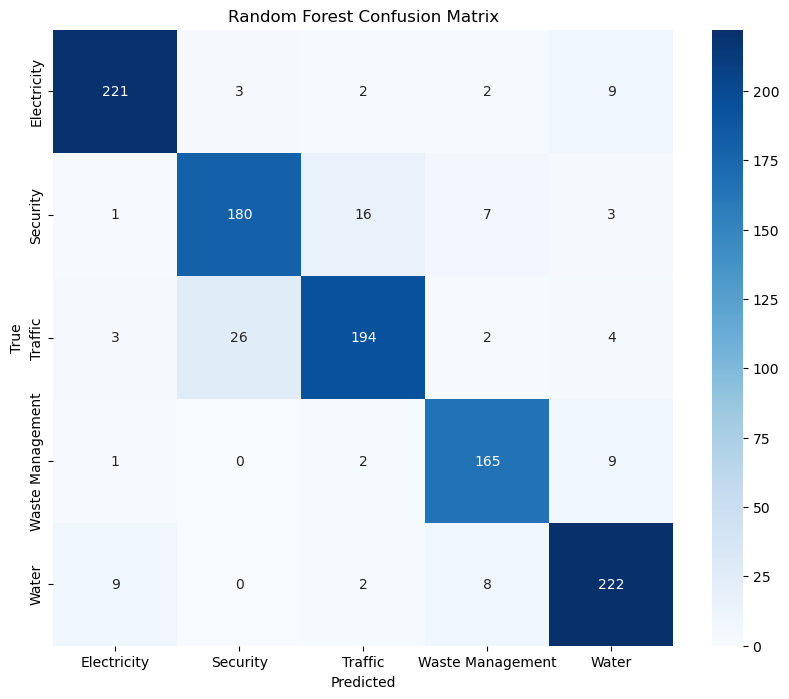

Model, vectorizer, and label encoder saved successfully.


In [26]:


# Load the JSON Lines file
file_path = 'preprocessed_reddit_social_issues_cleaned.json'  # Update with your actual path
try:
    data = pd.read_json(file_path, lines=True)
    print("Dataset Head:")
    print(data.head())
    print("\nColumns:", data.columns.tolist())
except ValueError as e:
    print(f"Error loading JSON: {e}")
    print("Please verify the file is in JSON Lines format or share its structure.")
    exit(1)

# Extract text and labels
if 'text' not in data.columns or 'label' not in data.columns:
    print("Required columns 'text' and 'label' not found. Available columns:", data.columns.tolist())
    print("Please specify correct column names.")
    exit(1)

X_text = data['text']
y = data['label']

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
print("\nClasses:", label_encoder.classes_)

# Extract additional features if available
use_additional_features = False
if 'sentiment' in data.columns and 'urgent' in data.columns:
    X_sentiment = data['sentiment'].values.reshape(-1, 1)
    X_urgent = data['urgent'].values.reshape(-1, 1)
    use_additional_features = True
    print("Using sentiment and urgency features.")
else:
    print("Sentiment or urgency features not found. Using only text features.")

# Split the data
if use_additional_features:
    X_text_train, X_text_test, X_sentiment_train, X_sentiment_test, X_urgent_train, X_urgent_test, y_train, y_test = train_test_split(
        X_text, X_sentiment, X_urgent, y_encoded, test_size=0.2, random_state=42
    )
else:
    X_text_train, X_text_test, y_train, y_test = train_test_split(
        X_text, y_encoded, test_size=0.2, random_state=42
    )

# Apply TF-IDF vectorization
tfidf = TfidfVectorizer(max_features=5000, stop_words='english')
X_text_train_tfidf = tfidf.fit_transform(X_text_train)
X_text_test_tfidf = tfidf.transform(X_text_test)

# Combine features
if use_additional_features:
    X_train_combined = np.hstack((X_text_train_tfidf.toarray(), X_sentiment_train, X_urgent_train))
    X_test_combined = np.hstack((X_text_test_tfidf.toarray(), X_sentiment_test, X_urgent_test))
else:
    X_train_combined = X_text_train_tfidf
    X_test_combined = X_text_test_tfidf

# Train Random Forest
rf_model = RandomForestClassifier(n_estimators=100, max_depth=None, random_state=42)
rf_model.fit(X_train_combined, y_train)

# Evaluate
y_pred_rf = rf_model.predict(X_test_combined)
print("\nRandom Forest Classification Report:")
print(classification_report(y_test, y_pred_rf, target_names=label_encoder.classes_))

# Confusion matrix
cm_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Random Forest Confusion Matrix')
plt.savefig('modeling_RF_TFIDF/rf_confusion_matrix.png')
plt.show()
plt.close()

# Save model and components
joblib.dump(rf_model, 'modeling_RF_TFIDF/rf_model.pkl')
joblib.dump(tfidf, 'modeling_RF_TFIDF/tfidf_vectorizer.pkl')
joblib.dump(label_encoder, 'modeling_RF_TFIDF/label_encoder.pkl')
print("Model, vectorizer, and label encoder saved successfully.")

### LSTM 

In [28]:
os.makedirs('modeling_LSTM', exist_ok=True)

In [59]:
import pandas as pd
import numpy as np
import random
import os
import torch
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, Dense, Concatenate, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import joblib

In [46]:
import torch

# Initial memory
print(f"Before tensor allocation:")
print(f"Allocated: {torch.cuda.memory_allocated() / 1024**2:.2f} MiB")
print(f"Reserved: {torch.cuda.memory_reserved() / 1024**2:.2f} MiB")

# Allocate a large tensor
x = torch.randn((10000, 1000), device='cuda')

# Memory after allocation
print(f"\nAfter tensor allocation:")
print(f"Allocated: {torch.cuda.memory_allocated() / 1024**2:.2f} MiB")
print(f"Reserved: {torch.cuda.memory_reserved() / 1024**2:.2f} MiB")


Before tensor allocation:
Allocated: 20.00 MiB
Reserved: 20.00 MiB

After tensor allocation:
Allocated: 54.33 MiB
Reserved: 60.00 MiB


In [43]:
import numpy as np
# Verify GPU and environment
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Active Conda Env: {os.environ.get('CONDA_DEFAULT_ENV')}")
print(f"CUDA Available: {torch.cuda.is_available()}")
print(f"Using Device: {device}")
if torch.cuda.is_available():
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")
    print(f"VRAM Allocated: {torch.cuda.memory_allocated(0)/1024**2:.2f} MiB")

Active Conda Env: ai_env
CUDA Available: True
Using Device: cuda
GPU Name: NVIDIA GeForce MX450
VRAM Allocated: 20.00 MiB


In [44]:
import torch
print(f"Allocated: {torch.cuda.memory_allocated() / 1024**2:.2f} MiB")
print(f"Reserved: {torch.cuda.memory_reserved() / 1024**2:.2f} MiB")
print(f"Total GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**2:.2f} MiB")


Allocated: 20.00 MiB
Reserved: 20.00 MiB
Total GPU Memory: 2047.75 MiB


Active Conda environment: ai_env
CUDA Available: True
Using device: cuda
GPU Name: NVIDIA GeForce MX450
VRAM Allocated: 50.5 MiB
Dataset Head:
                                                text        label  sentiment  \
0           loadshedding city recently new title say  Electricity      0.068   
1  loadsheddingpower breakdown dhabay jeegharo co...  Electricity      0.000   
2               shehbaz warn public loadshedde month  Electricity      0.167   
3  national grid reduce supply karachi shahbaz ta...  Electricity      0.525   
4  pakistan free loadshedde tonight midnight chai...  Electricity      0.400   

   urgent  
0   False  
1   False  
2   False  
3   False  
4   False  

Columns: ['text', 'label', 'sentiment', 'urgent']
Required columns 'text', 'label', 'sentiment', 'urgent' not found. Columns: ['text', 'label', 'sentiment', 'urgent']

Classes: ['Electricity' 'Security' 'Traffic' 'Waste Management' 'Water']

Class Weights: {0: 0.9892921960072595, 1: 1.0150837988826815,

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_21      │ (None, 512)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_7         │ (None, 512, 200)  │  1,000,000 │ input_layer_21[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_2     │ (None, 512, 512)  │    935,936 │ embedding_7[0][0] │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_3     │ (None, 256)       │    656,384 │ bidirectional_2[… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 256)       │          0 │ bidirectional_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_22      │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_23      │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_7       │ (None, 258)       │          0 │ dropout_7[0][0],  │
│ (Concatenate)       │                   │            │ input_layer_22[0… │
│                     │                   │            │ input_layer_23[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_15 (Dense)    │ (None, 256)       │     66,304 │ concatenate_7[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_16 (Dense)    │ (None, 128)       │     32,896 │ dense_15[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 128)       │          0 │ dense_16[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_17 (Dense)    │ (None, 5)         │        645 │ dropout_8[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,692,165 (10.27 MB)

 Trainable params: 2,692,165 (10.27 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
545/545 ━━━━━━━━━━━━━━━━━━━━ 438s 798ms/step - accuracy: 0.4172 - loss: 15.9471 - val_accuracy: 0.8130 - val_loss: 5.2072 - learning_rate: 1.0000e-04
Epoch 2/50
545/545 ━━━━━━━━━━━━━━━━━━━━ 425s 779ms/step - accuracy: 0.8166 - loss: 4.3795 - val_accuracy: 0.8836 - val_loss: 2.7148 - learning_rate: 1.0000e-04
Epoch 3/50
545/545 ━━━━━━━━━━━━━━━━━━━━ 372s 682ms/step - accuracy: 0.8677 - loss: 2.5252 - val_accuracy: 0.8818 - val_loss: 1.9735 - learning_rate: 1.0000e-04
Epoch 4/50
545/545 ━━━━━━━━━━━━━━━━━━━━ 372s 683ms/step - accuracy: 0.8922 - loss: 1.8537 - val_accuracy: 0.8900 - val_loss: 1.5657 - learning_rate: 1.0000e-04
Epoch 5/50
545/545 ━━━━━━━━━━━━━━━━━━━━ 364s 668ms/step - accuracy: 0.9099 - loss: 1.4306 - val_accuracy: 0.8863 - val_loss: 1.2856 - learning_rate: 1.0000e-04
Epoch 6/50
545/545 ━━━━━━━━━━━━━━━━━━━━ 375s 688ms/step - accuracy: 0.9079 - loss: 1.1796 - val_accuracy: 0.8891 - val_loss: 1.1074 - learning_rate: 1.0000e-04
Epoch 7/50
545/545 ━━━━━━━━━━━━━━━━━━━━

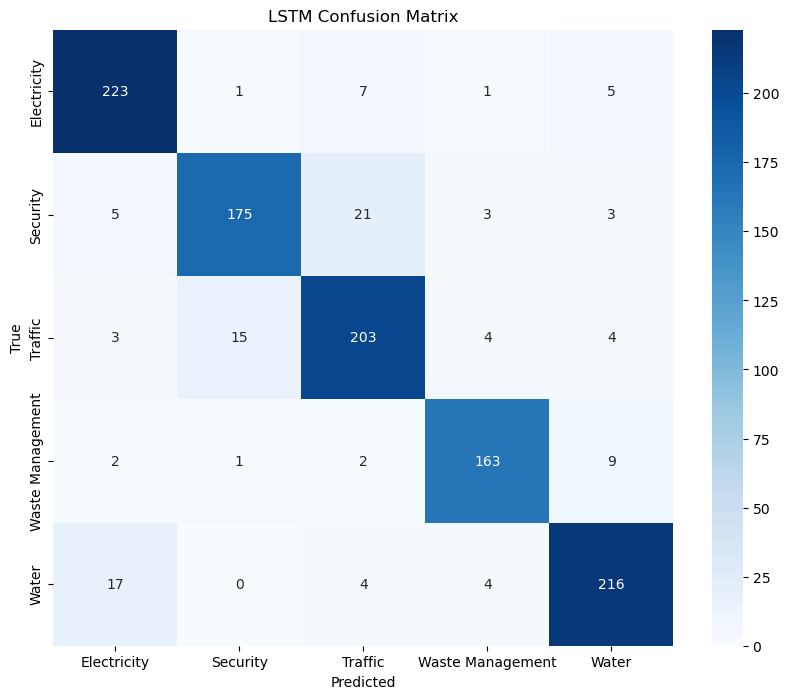

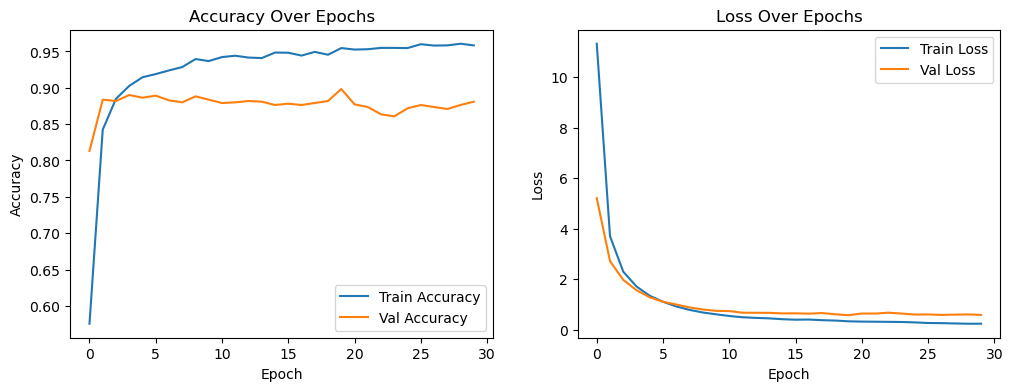

Model, tokenizer, label encoder, and scaler saved successfully.


In [62]:
import pandas as np
import pandas as pd
import random
import os
import torch
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, Dense, Dropout, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
import joblib

# Verify GPU and environment
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Active Conda environment: {os.environ.get('CONDA_DEFAULT_ENV')}")
print(f"CUDA Available: {torch.cuda.is_available()}")
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")
    print(f"VRAM Allocated: {torch.cuda.memory_allocated(0)/1024**2:.1f} MiB")

# Set random seeds for reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

# Load JSON Lines file
file_path = 'preprocessed_reddit_social_issues_cleaned.json'  # Update path
try:
    data = pd.read_json(file_path, lines=True)
    print("Dataset Head:")
    print(data.head())
    print("\nColumns:", data.columns.tolist())
except ValueError as e:
    print(f"Error loading JSON: {e}")
    exit(1)

# Extract text, labels, and additional features
if 'text' not in data.columns or 'label' not in data.columns or 'sentiment' or 'urgent' not in data.columns:
    print("Required columns 'text', 'label', 'sentiment', 'urgent' not found. Columns:", data.columns.tolist())
    exit(1)

X_text = data['text']
y = data['label']
X_sentiment = data['sentiment'].values.reshape(-1, 1)
X_urgent = data['urgent'].values.reshape(-1, 1)

# Scale additional features
scaler = StandardScaler()
X_sentiment_scaled = scaler.fit_transform(X_sentiment)
X_urgent_scaled = scaler.fit_transform(X_urgent)
joblib.dump(scaler, 'modeling_LSTM/scaler.pkl')

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
num_classes = len(label_encoder.classes_)
print("\nClasses:", label_encoder.classes_)

# Compute class weights to handle imbalance
class_weights = compute_class_weight('balanced', classes=np.unique(y_encoded), y=y_encoded)
class_weight_dict = dict(zip(range(num_classes), class_weights))
print("\nClass Weights:", class_weight_dict)

# Split data
X_text_train, X_text_test, X_sentiment_train, X_sentiment_test, X_urgent_train, X_urgent_test, y_train, y_test = train_test_split(
    X_text, X_sentiment_scaled, X_urgent_scaled, y_encoded, test_size=0.2, random_state=seed
)

# Text preprocessing
max_words = 5000
max_len = 512  # Increased for longer posts
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_text_train)
X_train_seq = tokenizer.texts_to_sequences(X_text_train)
X_test_seq = tokenizer.texts_to_sequences(X_text_test)
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)

# Check text length distribution
text_lengths = [len(text.split()) for text in X_text]
print(f"\nText Length Stats: Mean={np.mean(text_lengths):.1f}, Max={np.max(text_lengths)}, 95th Percentile={np.percentile(text_lengths, 95):.1f}")

# Load GloVe Twitter embeddings (200d)
embedding_dim = 200
glove_file = 'modeling_LSTM/glove.twitter.27B.200d.txt'  # Update path
word_index = tokenizer.word_index
embedding_matrix = np.zeros((max_words, embedding_dim))
print("Loading GloVe Twitter 200d embeddings...")
with open(glove_file, encoding='utf-8') as f:
    for line in f:
        word, *vector = line.split()
        if word in word_index and word_index[word] < max_words:
            embedding_matrix[word_index[word]] = np.array(vector, dtype=np.float32)
print("GloVe embeddings loaded.")

# Build LSTM model
text_input = Input(shape=(max_len,))
embedding_layer = Embedding(max_words, embedding_dim, weights=[embedding_matrix], trainable=True)(text_input)
lstm1 = Bidirectional(LSTM(256, return_sequences=True, kernel_regularizer=l2(0.01)))(embedding_layer)
lstm2 = Bidirectional(LSTM(128, kernel_regularizer=l2(0.01)))(lstm1)
dropout = Dropout(0.3)(lstm2)

sentiment_input = Input(shape=(1,))
urgent_input = Input(shape=(1,))
combined = Concatenate()([dropout, sentiment_input, urgent_input])
dense1 = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(combined)
dense2 = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(dense1)
dropout2 = Dropout(0.3)(dense2)
output = Dense(num_classes, activation='softmax')(dropout2)

model = Model(inputs=[text_input, sentiment_input, urgent_input], outputs=output)
model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

# Train model with callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
history = model.fit(
    [X_train_pad, X_sentiment_train, X_urgent_train], y_train,
    validation_data=([X_test_pad, X_sentiment_test, X_urgent_test], y_test),
    epochs=50, batch_size=8,  # Smaller batch size for better gradients
    class_weight=class_weight_dict,  # Handle class imbalance
    callbacks=[early_stopping, lr_scheduler]
)

# Evaluate
y_pred_prob = model.predict([X_test_pad, X_sentiment_test, X_urgent_test])
y_pred = np.argmax(y_pred_prob, axis=1)

print("\nLSTM Classification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('LSTM Confusion Matrix')
plt.savefig('modeling_LSTM/lstm_confusion_matrix.png')
plt.show()
plt.close()

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig('modeling_LSTM/training_history.png')
plt.show()
plt.close()

# Save model and components
model.save('modeling_LSTM/lstm_model.h5')
joblib.dump(tokenizer, 'modeling_LSTM/tokenizer.pkl')
joblib.dump(label_encoder, 'modeling_LSTM/label_encoder.pkl')
joblib.dump(scaler, 'modeling_LSTM/scaler.pkl')
print("Model, tokenizer, label encoder, and scaler saved successfully.")

In [32]:
import numpy as np  # This is the standard import convention
print(f"numpy version: {np.__version__}")

numpy version: 1.26.4
